# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 23699 entries, 0 to 23698

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   total_images          23699 non-null  int64  

 1   last_price            23699 non-null  float64

 2   total_area            23699 non-null  float64

 3   first_day_exposition  23699 non-null  object 

 4   rooms                 23699 non-null  int64  

 5   ceiling_height        14504 non-null  float64

 6   floors_total          23613 non-null  float64

 7   living_area           21796 non-null  float64

 8   floor                 23699 non-null  int64  

 9   is_apartment          2775 non-null   object 

 10  studio                23699 non-null  bool   

 11  open_plan             23699 non-null  bool   

 12  kitchen_area          21421 non-null  float64

 13  balcony               12180 non-null  float64

 14  locality_name         23650 non-null  object 

 15 

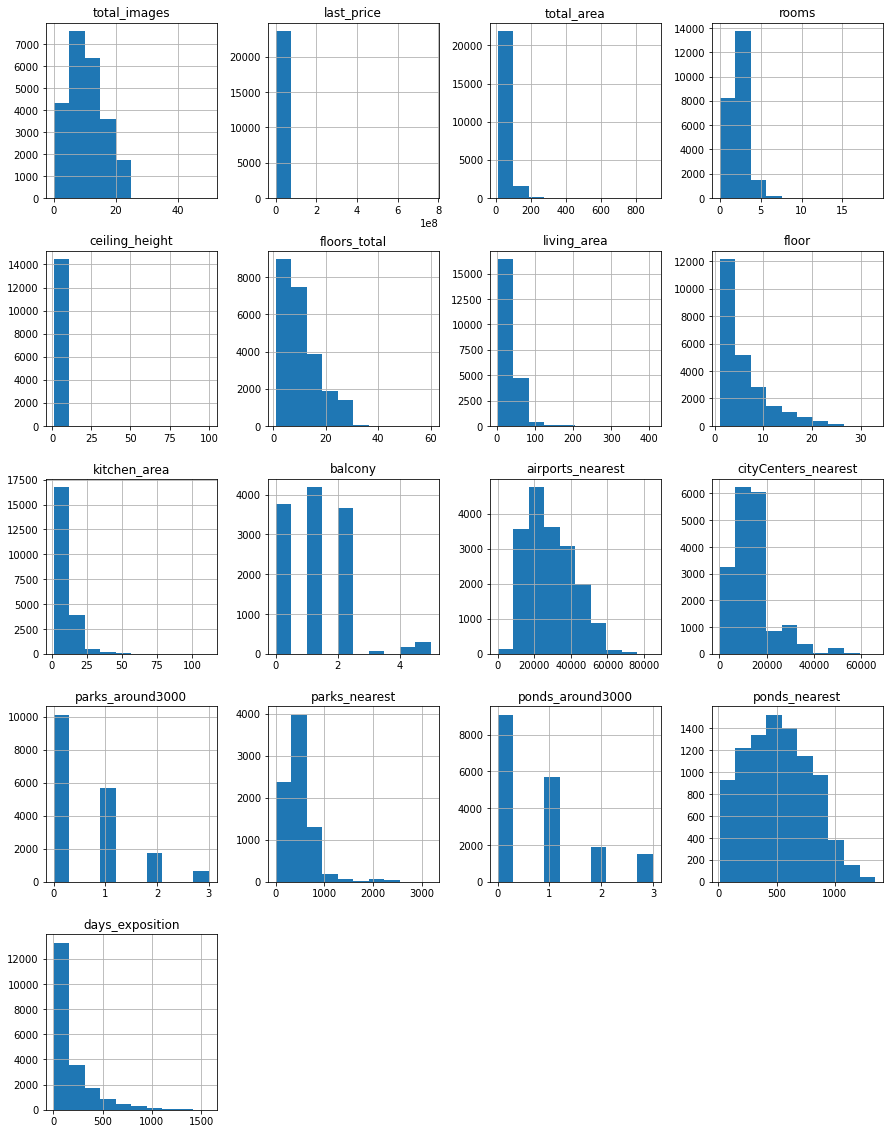

In [4]:
data.hist(figsize=(15, 20));

In [5]:
data.duplicated().sum()

0

В данных нет строк с явными дубликатами.

### Предобработка данных

#### Обработка пропусков

Пропуски есть в следующих столбцах:
- ceiling_height        **высота потолков**
- floors_total          **всего этажей в доме**
- living_area           **жилая площадь в квадратных метрах**
- is_apartment          **апартаменты (булев тип)**
- kitchen_area          **площадь кухни в квадратных метрах**
- balcony               **число балконов**
- locality_name         **название населённого пункта**
- airports_nearest      **расстояние до ближайшего аэропорта в метрах**
- cityCenters_nearest   **расстояние до центра города**
- parks_around3000      **число парков в радиусе 3 км**
- parks_nearest         **расстояние до ближайшего парка**
- ponds_around3000      **число водоёмов в радиусе 3 км**
- ponds_nearest         **расстояние до ближайшего водоёма**
- days_exposition       **сколько дней было размещено объявление**

In [6]:
# код ревьюера
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
total_images,0.00%
open_plan,0.00%
floor,0.00%
rooms,0.00%
studio,0.00%
total_area,0.00%
last_price,0.00%
first_day_exposition,0.00%
locality_name,0.21%
floors_total,0.36%


Возможно заполнить следующие пропуски:
- is_apartment заменить False
- balcony заменить 0, так как балкон отсутсвует
- parks_around3000 заменить 0
- ponds_around3000 заменить 0

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data['balcony'] = data['balcony'].fillna(value=0)
data['parks_around3000'] = data['parks_around3000'].fillna(value=0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0)

А пропуски в столбцах floors_total, living_area, locality_name можно отбросить, так как они представляют малую долю выборки и их невозможно заполнить. При этом они будут мешать дальнейшер раборте с данными.

In [8]:
data = data.dropna(subset=['floors_total', 'living_area', 'locality_name'])
data = data.reset_index(drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 21700 entries, 0 to 21699

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   total_images          21700 non-null  int64  

 1   last_price            21700 non-null  float64

 2   total_area            21700 non-null  float64

 3   first_day_exposition  21700 non-null  object 

 4   rooms                 21700 non-null  int64  

 5   ceiling_height        13687 non-null  float64

 6   floors_total          21700 non-null  float64

 7   living_area           21700 non-null  float64

 8   floor                 21700 non-null  int64  

 9   is_apartment          21700 non-null  bool   

 10  studio                21700 non-null  bool   

 11  open_plan             21700 non-null  bool   

 12  kitchen_area          20905 non-null  float64

 13  balcony               21700 non-null  float64

 14  locality_name         21700 non-null  object 

 15 

**Вывод:**
Обнаружены пропуски во многих столбцах, заполнены пропуски в некоторых из них, удалены строки, в которых имеются пропуски в столбцах с необходимыми данными, не поддающимися заполнению.
Причиной большинства пропусков может являться неполное заполнение информации в объявлениях. Пропуски в столбцах с жилой площадью и этажом могли появиться при переносе или выгрузке данных.

#### Обработка типов данных

Я считаю, что необходимо изменить тип данных для следующих столбцов:
- first_day_exposition перевести тип в датовый, для дальнейшей работы
- floors_total изменить на целочисленнный
- balcony изменить на целочисленнный
- parks_around3000 изменить на целочисленнный
- ponds_around3000 изменить на целочисленнный

In [10]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)

In [11]:
data['floors_total'] = data['floors_total'].astype('int', errors='ignore')
data['balcony'] = data['balcony'].astype('int', errors='ignore')
data['parks_around3000'] = data['parks_around3000'].astype('int', errors='ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int', errors='ignore')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 21700 entries, 0 to 21699

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype         

---  ------                --------------  -----         

 0   total_images          21700 non-null  int64         

 1   last_price            21700 non-null  float64       

 2   total_area            21700 non-null  float64       

 3   first_day_exposition  21700 non-null  datetime64[ns]

 4   rooms                 21700 non-null  int64         

 5   ceiling_height        13687 non-null  float64       

 6   floors_total          21700 non-null  int64         

 7   living_area           21700 non-null  float64       

 8   floor                 21700 non-null  int64         

 9   is_apartment          21700 non-null  bool          

 10  studio                21700 non-null  bool          

 11  open_plan             21700 non-null  bool          

 12  kitchen_area          20905 non-null  float64       

 13

**Вывод:**
Изменен формат столбца с датой, и нескольких столбцов, в которых должны находится целые значения.

#### Обработка дубликатов

In [13]:
print(len(data['locality_name'].unique()))
sorted(data['locality_name'].unique())

348


['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городской посёлок Янино-1',
 'деревня Аг

Изучив список уникальных значений столбца 'locality_name', было принято решение заменить все 'ё' на 'е' и сократить названия, такие как 'посёлок городского типа' и подобные оставив только имена собственные.

In [14]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('городской ', '')
data['locality_name'] = data['locality_name'].str.replace('деревня ', '')
data['locality_name'] = data['locality_name'].str.replace('поселок ', '')
data['locality_name'] = data['locality_name'].str.replace('городского типа ', '')
data['locality_name'] = data['locality_name'].str.replace('имени ', '')
data['locality_name'] = data['locality_name'].str.replace('станции ', '')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ', '')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной ', '')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ', '')
data['locality_name'] = data['locality_name'].str.replace('село ', '')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ', '')

In [16]:
print(len(data['locality_name'].unique()))
sorted(data['locality_name'].unique())

289


['Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпоселок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичево',
 'Калитино',
 'Каложицы',
 'Кальтино',


In [79]:
data.duplicated().sum()

0

**Вывод:**
Обнаружены и устранены неявные дубликаты в столбце 'locality_name'. Полные дубликаты строк так же отсутсвуют, после устранения неявных дубликаттов названий.

#### Обработка аномальных значений

<AxesSubplot:>

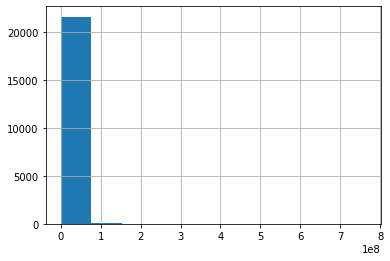

In [17]:
data['last_price'].hist(bins=10)

<AxesSubplot:>

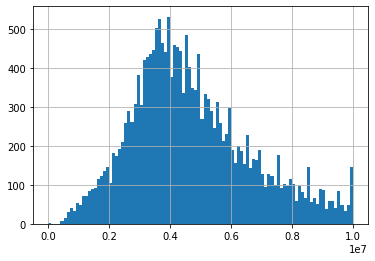

In [18]:
data['last_price'].hist(bins=100, range=(0, 10000000))

<AxesSubplot:>

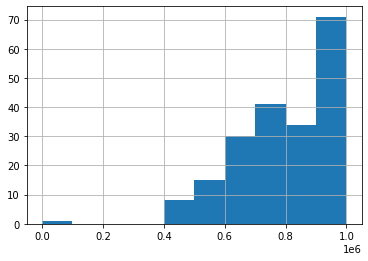

In [19]:
data['last_price'].hist(bins=10, range=(0, 1000000))

<AxesSubplot:>

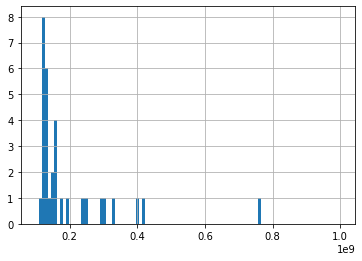

In [20]:
data['last_price'].hist(bins=100, range=(100000000, 1000000000))

In [21]:
data[data['last_price']==data['last_price'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8063,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8.0


In [22]:
data[data['last_price']==12000000.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1093,20,12000000.0,77.60,2019-04-26,2,3.54,3,46.64,3,False,...,11.40,0,Санкт-Петербург,24487.0,4054.0,1,710.0,3,272.0,NaN
1759,20,12000000.0,128.00,2018-09-11,4,2.80,14,63.20,4,False,...,30.00,0,Санкт-Петербург,41570.0,11703.0,1,493.0,0,NaN,4.0
2024,9,12000000.0,99.00,2019-02-27,2,NaN,17,49.00,16,False,...,NaN,0,Санкт-Петербург,26293.0,10466.0,1,390.0,0,NaN,NaN
2397,11,12000000.0,84.68,2017-06-19,2,NaN,9,45.40,8,False,...,16.40,0,Санкт-Петербург,32121.0,5080.0,0,NaN,3,457.0,127.0
2404,11,12000000.0,103.40,2017-09-19,3,3.25,4,61.10,3,False,...,10.20,1,Санкт-Петербург,20821.0,1283.0,1,287.0,2,29.0,201.0
3092,8,12000000.0,141.00,2019-03-27,3,2.70,5,73.00,1,False,...,15.20,0,Петергоф,38485.0,33674.0,1,240.0,1,752.0,13.0
3443,6,12000000.0,83.00,2017-12-08,2,NaN,7,28.00,5,False,...,26.00,0,Санкт-Петербург,21102.0,1589.0,2,476.0,2,315.0,507.0
3771,12,12000000.0,55.70,2017-08-02,3,3.00,6,36.00,6,False,...,NaN,1,Санкт-Петербург,24117.0,4526.0,1,473.0,0,NaN,69.0
4294,12,12000000.0,107.40,2018-09-17,4,3.60,6,76.80,2,False,...,10.00,1,Санкт-Петербург,23056.0,2598.0,0,NaN,3,707.0,21.0
4587,11,12000000.0,115.10,2018-02-27,4,2.93,4,70.90,4,False,...,16.10,0,Санкт-Петербург,22037.0,3440.0,0,NaN,0,NaN,90.0


In [23]:
data.loc[data['last_price']==data['last_price'].min(), ['last_price']] *= 1000

In [24]:
data[data['last_price']==data['last_price'].max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11897,19,763000000.0,400.0,2017-09-30,7,NaN,10,250.0,10,False,...,NaN,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33.0


На гистограмме стоимости объекта большая часть находится в диапазоне до 10.000.000, так же были обнаружены два отдаленных значения, минимальное и максимальное. При подробном изучении выявлено, что максимальное значение может оказаться правдоподобным, а минимальное ошибочно, скорее всего в нем пропущено три нуля, заменим это значение, увеличив его в 1000 раз.

In [25]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0, 11,  7,  8, 14, 10, 15,  9, 19, 16, 12])

In [26]:
data[data['rooms']==0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
133,1,2450000.0,27.00,2017-03-30,0,NaN,24,15.50,2,False,...,NaN,2,Мурино,NaN,NaN,0,NaN,0,NaN,181.0
324,4,2320000.0,25.00,2017-09-27,0,NaN,14,17.00,1,False,...,NaN,0,Кудрово,NaN,NaN,0,NaN,0,NaN,45.0
408,8,2480000.0,27.11,2018-03-12,0,NaN,17,24.75,4,False,...,NaN,2,Санкт-Петербург,38171.0,15015.0,0,NaN,2,982.0,64.0
471,0,3375000.0,34.40,2017-03-28,0,NaN,26,24.30,19,False,...,NaN,1,Парголово,53115.0,19292.0,0,NaN,1,593.0,430.0
643,12,2500000.0,24.10,2017-12-01,0,2.75,25,17.50,21,False,...,NaN,0,Кудрово,NaN,NaN,0,NaN,0,NaN,201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20946,2,4280000.0,28.00,2017-10-26,0,2.70,19,18.00,10,False,...,NaN,0,Санкт-Петербург,18982.0,7206.0,0,NaN,1,415.0,151.0
21249,7,3200000.0,26.00,2017-09-01,0,NaN,25,18.00,16,False,...,NaN,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14.0
21468,0,2500000.0,27.70,2017-09-28,0,NaN,24,18.00,4,False,...,NaN,2,Мурино,NaN,NaN,0,NaN,0,NaN,4.0
21604,10,1450000.0,29.00,2017-11-11,0,NaN,9,18.00,8,False,...,NaN,2,Никольское,NaN,NaN,0,NaN,0,NaN,82.0


Найден ряд записей, в которых в столбце 'rooms' указан 0. Стоит учитывать это при дальнейшей работе с данными.

<AxesSubplot:>

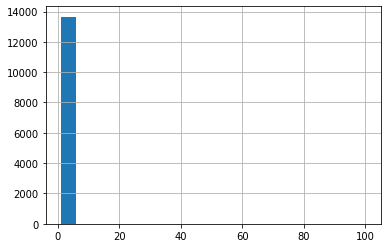

In [27]:
data['ceiling_height'].hist(bins=20)

<AxesSubplot:>

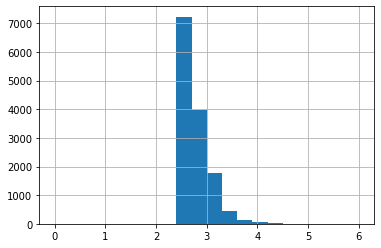

In [28]:
data['ceiling_height'].hist(bins=20, range=(0, 6))

In [29]:
data.groupby('ceiling_height')['ceiling_height'].count().tail(15)

ceiling_height
5.8      1
6.0      1
8.0      3
8.3      1
10.3     1
14.0     1
20.0     1
22.6     1
24.0     1
25.0     7
26.0     1
27.0     8
27.5     1
32.0     2
100.0    1
Name: ceiling_height, dtype: int64

Большая часть значений высоты потолков находится в диапазоне от 2,5 до 3,5 метров, учитывая это, значения более 20 метров, вероятно, указы непровильно и являются выщественными значениями с пропущенной точкой.

In [30]:
data.loc[data['ceiling_height']>=20.0, ['ceiling_height']] /= 10

<AxesSubplot:>

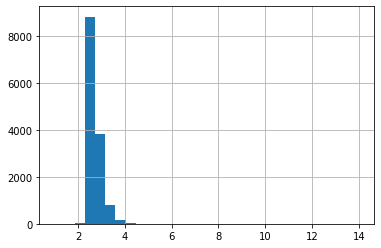

In [31]:
data['ceiling_height'].hist(bins=30)

<AxesSubplot:>

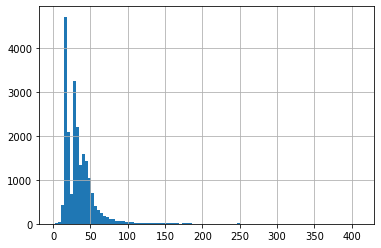

In [32]:
data['living_area'].hist(bins=100)

In [33]:
sorted(data['living_area'].unique())[:10]

[2.0, 3.0, 5.0, 5.4, 6.0, 6.5, 8.0, 8.3, 8.4, 8.5]

In [34]:
data[data['living_area']<10.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
105,5,4000000.0,21.40,2019-02-07,1,2.90,8,8.3,7,False,...,6.3,0,Санкт-Петербург,27089.0,5791.0,2,488.0,1,286.0,NaN
627,14,7200000.0,43.00,2017-10-31,1,NaN,8,9.0,2,False,...,23.0,0,Санкт-Петербург,23900.0,5232.0,1,2137.0,1,933.0,296.0
1219,8,8100000.0,52.00,2017-01-29,2,2.70,25,9.0,15,False,...,32.0,2,Санкт-Петербург,35555.0,15561.0,0,NaN,1,1180.0,337.0
2127,10,4200000.0,62.40,2017-06-15,2,2.60,9,8.4,6,False,...,41.0,2,Шушары,23662.0,29448.0,0,NaN,0,NaN,111.0
2969,7,4440000.0,41.00,2017-07-02,1,NaN,17,3.0,17,False,...,11.0,0,Санкт-Петербург,19272.0,13073.0,0,NaN,0,NaN,216.0
3762,17,5300000.0,34.80,2017-06-19,1,2.70,23,9.0,15,False,...,17.1,0,Санкт-Петербург,33626.0,13495.0,0,NaN,0,NaN,30.0
4166,12,3300000.0,18.00,2018-11-07,1,3.50,5,9.0,2,False,...,NaN,0,Санкт-Петербург,25157.0,4948.0,2,349.0,1,963.0,9.0
6695,8,3400000.0,27.00,2018-02-21,2,2.50,15,9.0,4,False,...,16.0,0,Санкт-Петербург,50246.0,16444.0,1,617.0,0,NaN,NaN
7620,9,4800000.0,52.00,2017-10-25,2,NaN,5,9.0,2,False,...,6.0,1,Санкт-Петербург,33358.0,13171.0,0,NaN,2,118.0,119.0
12762,20,6350000.0,52.00,2018-02-06,2,3.00,6,2.0,2,False,...,9.0,0,Санкт-Петербург,32453.0,6521.0,0,NaN,1,1012.0,91.0


Часть значений столбца 'living_area' является неправдоподобно маленькой, но в некоторых случаях это обусловлено маленькой общей площадью, что не позволяет применить единый метод решения. Возможно некоторые строки в этом столбце были заполнены некорректно, например указано 3, вместо 30.

**Вывод:**
Рассмотрены данные по всем столбцам (часть столбцов рассматривалась по гистограммам в начале проекта) и выявлены аномальные значения в следующих:
- last_pricе *обнаружено и исправлено одно аномально маленькое значение*
- rooms *обнаружен ряд записей с 0 комнат, обратить внимание при дальнейшем анализе*
- ceiling_height *обнаружен ряд аномально больших значений, значения 20 и более метров уменьшены в 10 раз*
- living_area *обнаружен ряд аномально маленьких значений, некоторые из них обусловлены маленькой общей площадью, другие могут являтся опечатками*

В остальных столбцах аномалий не выявлено.

#### Повторное заполнение пропусков

Можно заполнить пропуски в следующих столбцах:
- ceiling_height *средним значением высоты потолков*
- parks_nearest *3000, если в радиусе 3 км нет парков*
- ponds_nearest *3000, если в радиусе 3 км нет водоемов*
- airports_nearest *средним значением по населенному пункту*
- cityCenters_nearest *средним значением по населенному пункту*

In [35]:
data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())
data.loc[(data['parks_nearest'].isna()) & (data['parks_around3000']==0), 'parks_nearest'] = 3000
data.loc[(data['ponds_nearest'].isna()) & (data['ponds_around3000']==0), 'ponds_nearest'] = 3000

In [36]:
for t in data['locality_name'].unique():
    data.loc[(data['locality_name'] == t) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == t), 'airports_nearest'].median()
    data.loc[(data['locality_name'] == t) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == t), 'cityCenters_nearest'].median()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice

  return np.nanmean(a, axis, out=out, keepdims=keepdims)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice

  return np.nanmean(a, axis, out=out, keepdims=keepdims)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice

  return np.nanmean(a, axis, out=out, keepdims=keepdims)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice

  return np.nanmean(a, axis, out=out, keepdims=keepdims)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice

  return np.nanmean(a, axis, out=out, keepdims=keepdims)

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice

  return np.nanmean(a, axis, out=out, keepdims=keepdims)

/opt

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 21700 entries, 0 to 21699

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype         

---  ------                --------------  -----         

 0   total_images          21700 non-null  int64         

 1   last_price            21700 non-null  float64       

 2   total_area            21700 non-null  float64       

 3   first_day_exposition  21700 non-null  datetime64[ns]

 4   rooms                 21700 non-null  int64         

 5   ceiling_height        21700 non-null  float64       

 6   floors_total          21700 non-null  int64         

 7   living_area           21700 non-null  float64       

 8   floor                 21700 non-null  int64         

 9   is_apartment          21700 non-null  bool          

 10  studio                21700 non-null  bool          

 11  open_plan             21700 non-null  bool          

 12  kitchen_area          20905 non-null  float64       

 13

### Посчитайте и добавьте в таблицу новые столбцы

In [38]:
data['price_one_m'] = data['last_price'] / data['total_area']

In [39]:
data['day_week'] = pd.DatetimeIndex(data['first_day_exposition']).day_of_week

In [40]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [41]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [42]:
def floor_type (row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

In [43]:
data['cityCenters_km'] = round(data['cityCenters_nearest'] / 1000).astype('int', errors='ignore')

In [44]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_m,day_week,month,year,floor_type,cityCenters_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,3000.0,0,3000.0,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0
4,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,3000.0,0,3000.0,55.0,95065.789474,0,9,2018,другой,NaN


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 21700 entries, 0 to 21699

Data columns (total 28 columns):

 #   Column                Non-Null Count  Dtype         

---  ------                --------------  -----         

 0   total_images          21700 non-null  int64         

 1   last_price            21700 non-null  float64       

 2   total_area            21700 non-null  float64       

 3   first_day_exposition  21700 non-null  datetime64[ns]

 4   rooms                 21700 non-null  int64         

 5   ceiling_height        21700 non-null  float64       

 6   floors_total          21700 non-null  int64         

 7   living_area           21700 non-null  float64       

 8   floor                 21700 non-null  int64         

 9   is_apartment          21700 non-null  bool          

 10  studio                21700 non-null  bool          

 11  open_plan             21700 non-null  bool          

 12  kitchen_area          20905 non-null  float64       

 13

### Проведите исследовательский анализ данных

#### Изучение параметров объектов

<AxesSubplot:>

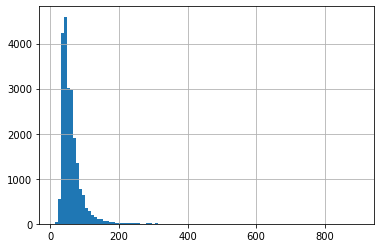

In [46]:
data['total_area'].hist(bins=100)

<AxesSubplot:>

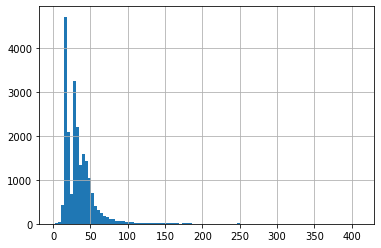

In [47]:
data['living_area'].hist(bins=100)

<AxesSubplot:>

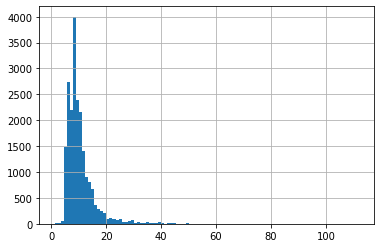

In [48]:
data['kitchen_area'].hist(bins=100)

<AxesSubplot:>

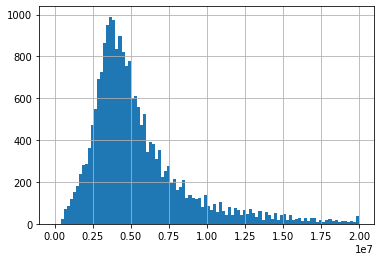

In [49]:
data['last_price'].hist(bins=100, range=(0, 20000000))

<AxesSubplot:>

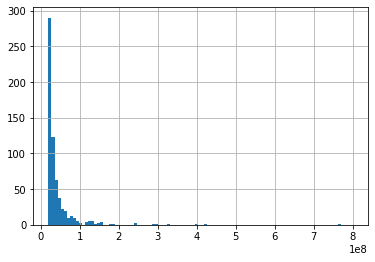

In [50]:
data['last_price'].hist(bins=100, range=(20000000,800000000))

<AxesSubplot:>

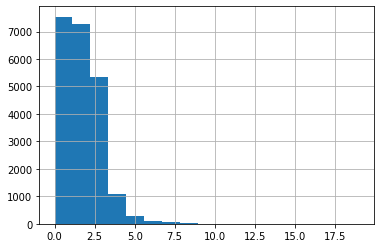

In [51]:
data['rooms'].hist(bins=data['rooms'].nunique())

<AxesSubplot:>

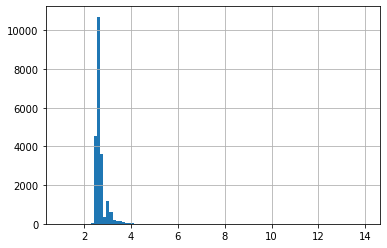

In [52]:
data['ceiling_height'].hist(bins=100)

<AxesSubplot:>

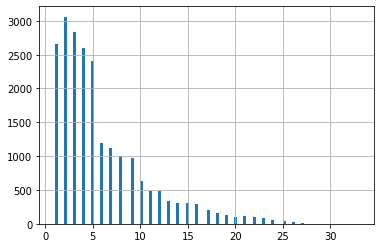

In [53]:
data['floor'].hist(bins=100)

<AxesSubplot:>

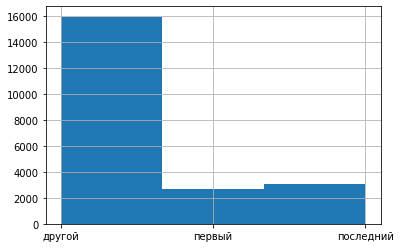

In [54]:
data['floor_type'].hist(bins=3)

<AxesSubplot:>

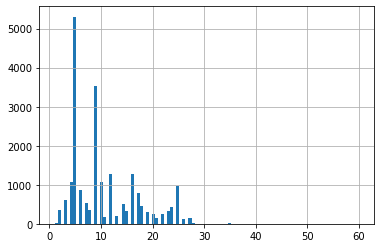

In [55]:
data['floors_total'].hist(bins=100)

<AxesSubplot:>

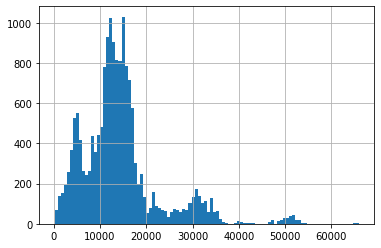

In [56]:
data['cityCenters_nearest'].hist(bins=100)

<AxesSubplot:>

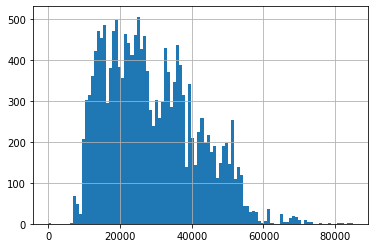

In [57]:
data['airports_nearest'].hist(bins=100)

<AxesSubplot:>

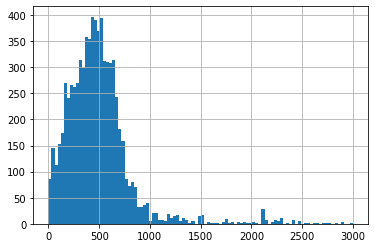

In [58]:
data['parks_nearest'].hist(bins=100, range=(0, 2999))

<AxesSubplot:>

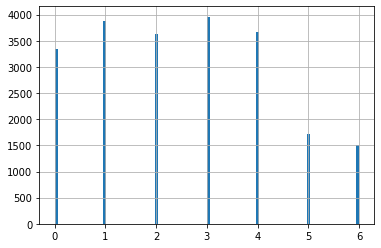

In [59]:
data['day_week'].hist(bins=100)

<AxesSubplot:>

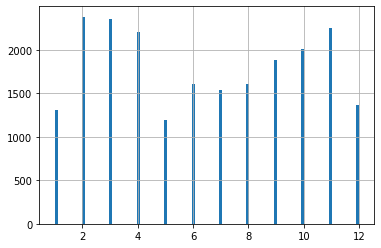

In [60]:
data['month'].hist(bins=100)

**Вывод:**
При исследовании данных были выявлены следующие наблюдения:
  - общая площадь, большая часть квартир имеет общую площадь до 100 квадратных метров;
  - жилая площадь, большая часть квартир имеет жилую площадь до 50 квадратных метров;
  - площадь кухни, большая часть квартир имеет общую площадь до 15 квадратных метров;
  - цена объекта, большая часть находится в диапазоне от 400.000 до 10.000.000, но так же есть значительно более дорогие;
  - количество комнат, чаще всего встречаются квартиры с 1, 2 или 3 комнатами;
  - высота потолков, варьируется от 2 до 3 метров, есть несколько слишком низких значений (около метра) и некоторые слишком большие;
  - этаж квартиры, больше всего квартир до пятого этажа;
  - тип этажа квартиры («первый», «последний», «другой»), квартиры на первом и последнем этаже встречаются реже, чем на других;
  - общее количество этажей в доме, наиболее частые пятиэтажные и девятиэтажные дома;
  - расстояние до центра города в метрах, большая часть находится в пределах 20 километров от центра, но есть и удаленные;
  - расстояние до ближайшего аэропорта, чаще всего аэропорт находится в 10-40 километрах;
  - расстояние до ближайшего парка, чаще всего расположен менее чем в 1 километре от здания;
  - день и месяц публикации объявления, на выходных публикуется меньше объявлений, чем в будни, так же спад публикаций есть в декабрь-январь и в мае.

#### Изучение, как быстро продавались квартиры

<AxesSubplot:>

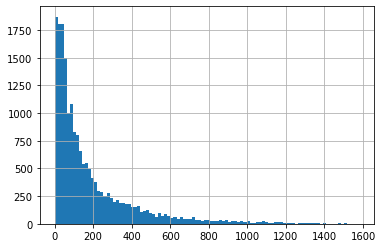

In [61]:
data['days_exposition'].hist(bins=100)

<AxesSubplot:>

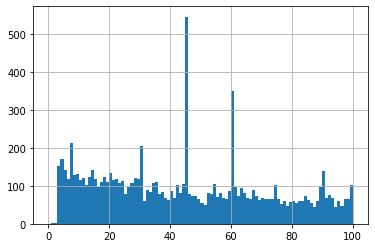

In [62]:
data['days_exposition'].hist(bins=100, range=(0,100))

In [63]:
data['days_exposition'].mean()

184.74289681691945

In [64]:
data['days_exposition'].median()

101.0

**Вывод:**
Обычно продажа занимает до 200 дней. Продажи за 3 и меньше дней необычно быстрые, а более 1000 слишком долгие. Так же есть значительное количество продаж на 45 и 60 день.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

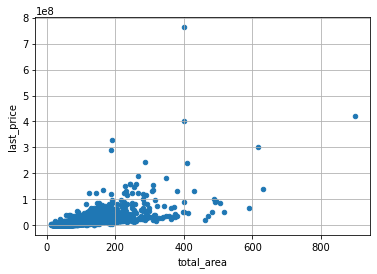

In [65]:
data.plot(x='total_area', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

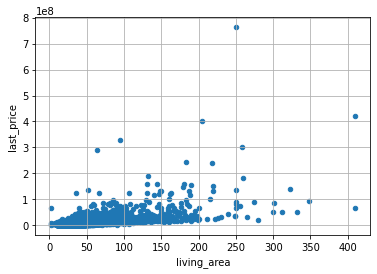

In [66]:
data.plot(x='living_area', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

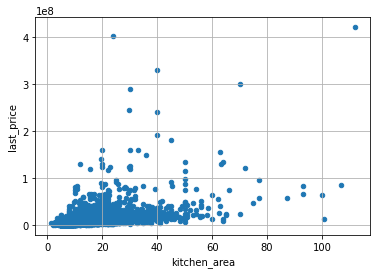

In [67]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

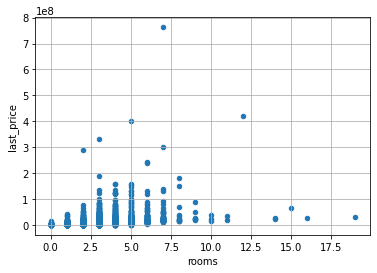

In [68]:
data.plot(x='rooms', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='floor', ylabel='last_price'>

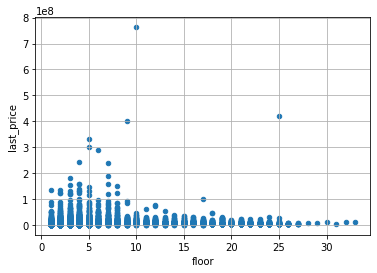

In [69]:
data.plot(x='floor', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='day_week', ylabel='last_price'>

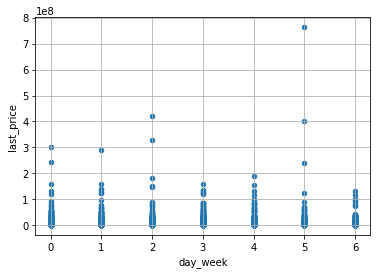

In [70]:
data.plot(x='day_week', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='month', ylabel='last_price'>

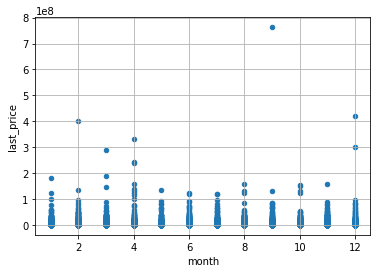

In [71]:
data.plot(x='month', y='last_price', kind='scatter', grid=True)

<AxesSubplot:xlabel='year', ylabel='last_price'>

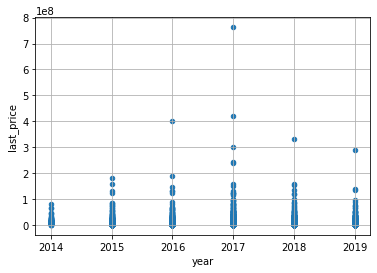

In [72]:
data.plot(x='year', y='last_price', kind='scatter', grid=True)

In [88]:
data.corr()['last_price'][['total_area', 'living_area', 'kitchen_area', 'rooms', 'floor', 'day_week', 'month', 'year']]

total_area      0.641482
living_area     0.566375
kitchen_area    0.518271
rooms           0.361049
floor           0.026538
day_week       -0.000496
month           0.001438
year           -0.038792
Name: last_price, dtype: float64

**Вывод:**
На общую стоимость объекта больше влияют параметры общей, жилой и кухонной площади, а так же количество комнат. День, месяц, год и этаж оказывают незначительное влияние.

#### Средняя цена одного кв.метра по населенным пунктам

In [74]:
# Получим названия 10 населённых пунктов с наибольшим числом объявлений
popular_local = data.groupby('locality_name')['locality_name'].count().sort_values()[-10:].to_frame()
popular_local

,locality_name
locality_name,
Петергоф,197
Гатчина,292
Парголово,301
Колпино,328
Пушкин,345
Всеволожск,371
Шушары,403
Кудрово,422
Мурино,524


In [75]:
for locality in popular_local.index:
    popular_local.loc[locality, 'avg_price'] = (
        data[data['locality_name']==locality]['last_price']/
        data[data['locality_name']==locality]['total_area']
    ).mean()

In [76]:
# код ревьюера
popular_local = data.groupby('locality_name')['price_one_m'].agg(['size', 'mean']).reset_index()
popular_local.columns = ['locality_name', 'flat_count', 'avg_price']
popular_local = popular_local.sort_values(by='flat_count').tail(10)

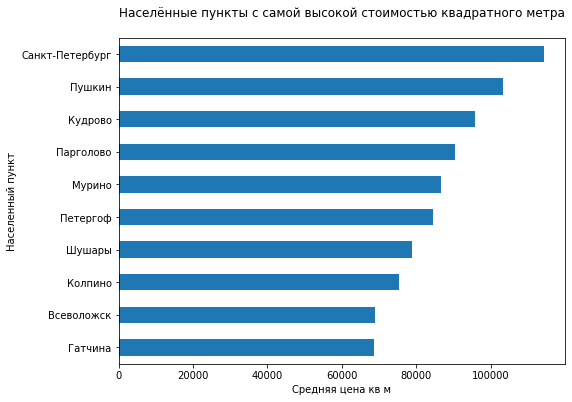

In [77]:
# код ревьюера 

import matplotlib.pyplot as plt

popular_local.sort_values(by='avg_price').tail(10).plot(x='locality_name', y='avg_price', kind='barh', figsize=(8,6), legend=False)
plt.xlabel('Средняя цена кв м')
plt.ylabel('Населенный пункт')
plt.title('Населённые пункты с самой высокой стоимостью квадратного метра\n')
plt.show()

**Вывод:** 
Из 10 населенных пунктов с наибольшим количеством объявлений самая высокая средняя стоимость одного квадратного метра в Санкт-Петербурге, а самая низкая в Гатчине.

#### Средняя цена каждого километра от центра в Санкт-Петербурге

<AxesSubplot:xlabel='cityCenters_km'>

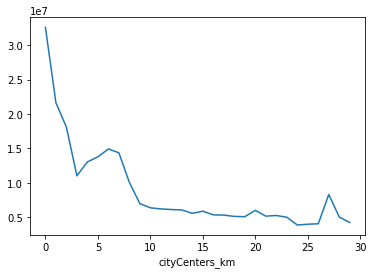

In [78]:
data.loc[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters_km')['last_price'].mean().plot()

**Вывод:**
При удалении от центра стоимость уменьшается. 

### Общий вывод

Было проведено исследование данных с целью найти интересные особенности и зависимости, которые существуют на рынке недвижимости. В качестве входных данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Выполнены следующие шаги:
- Устранены пропуски, неявные дубликаты и аномальные значения;
- Добавлены новые столбцы для исслдеования;
- Изучены некоторые параметры и описаны полученные наблюдения;
- Рассмотрено, как быстро продаются квартиры, средние значения и необычные;
- Изучено влияние различных факторов на стоимость;
- Расчитана средняя стоимость квадратного метра в 10 населенных пунктах с наибольшим числом объявлений;
- Рассмотрена средняя цена каждого километра от центра в Санкт-Петербурге.

**Результаты**

**Вопрос 1. Как быстро продавались квартиры?**
Обычно продажа занимает до 200 дней. Продажи за 3 и меньше дней необычно быстрые, а более 1000 слишком долгие. Так же есть значительное количество продаж на 45 и 60 день.

**Вопрос 2. Какие факторы больше всего влияют на общую (полную) стоимость объекта?**
На общую стоимость объекта больше влияют параметры общей, жилой и кухонной площади, а так же количество комнат. День, месяц, год и этаж оказывают незначительное влияние.

**Вопрос 3. Какие населённые пункты с самой высокой и низкой стоимостью квадратного метра?**
Из 10 населенных пунктов с наибольшим количеством объявлений самая высокая средняя стоимость одного квадратного метра в Санкт-Петербурге, а самая низкая в Гатчине.

**Вопрос 4. Как стоимость объектов зависит от расстояния до центра города?**
При удалении от центра стоимость уменьшается. 